<a href="https://colab.research.google.com/github/vinismachadoo/aviacao_civil_brasil/blob/main/controle_estatistico_voos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle --quiet

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!kaggle datasets download -d ramirobentes/flights-in-brazil

 92% 73.0M/79.3M [00:03<00:00, 17.4MB/s]
100% 79.3M/79.3M [00:03<00:00, 23.0MB/s]


In [4]:
!unzip flights-in-brazil.zip

Archive:  flights-in-brazil.zip
  inflating: BrFlights2.csv          
  inflating: BrFlights2/BrFlights2.csv  


In [5]:
!pip install geopandas --quiet

     |████████████████████████████████| 972kB 1.4MB/s 
     |████████████████████████████████| 10.9MB 373kB/s 
     |████████████████████████████████| 14.8MB 313kB/s 


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import seaborn as sns
from matplotlib.cbook import boxplot_stats
import os
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
voos_brasil = pd.read_csv('BrFlights2.csv', encoding='ISO-8859-1')

In [9]:
#Escolhemos trabalhar apenas com voos regionais e nacionais, portanto deletando quaisquer origem ou destino internacional
voos_brasil = voos_brasil[~voos_brasil['Codigo.Tipo.Linha'].isin(['Internacional'])]

In [10]:
voos_brasil.shape

(2221559, 21)

In [11]:
voos_brasil.head()

,Voos,Companhia.Aerea,Codigo.Tipo.Linha,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,Cidade.Origem,Estado.Origem,Pais.Origem,Aeroporto.Destino,Cidade.Destino,Estado.Destino,Pais.Destino,LongDest,LatDest,LongOrig,LatOrig
2659,AZU - 2400,AZUL,Regional,2016-01-18T08:25:00Z,NaN,2016-01-18T09:32:00Z,NaN,Cancelado,AUTORIZADO,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553
2660,AZU - 2400,AZUL,Regional,2016-01-26T08:25:00Z,NaN,2016-01-26T09:32:00Z,NaN,Cancelado,AUTORIZADO,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553
2661,AZU - 2400,AZUL,Regional,2016-01-22T08:25:00Z,NaN,2016-01-22T09:32:00Z,NaN,Cancelado,AUTORIZADO,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553
2662,AZU - 2400,AZUL,Regional,2016-01-16T08:25:00Z,NaN,2016-01-16T09:32:00Z,NaN,Cancelado,CANCELAMENTO - AEROPORTO DESTINO ABAIXO LIMITES,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553
2663,AZU - 2400,AZUL,Regional,2016-01-01T08:25:00Z,NaN,2016-01-01T09:32:00Z,NaN,Cancelado,AUTORIZADO,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553


In [12]:
#Acertando as colunas com dia e hora para formato datetime
voos_brasil['Partida.Prevista'] = pd.to_datetime(voos_brasil['Partida.Prevista'], format="%Y-%m-%dT%H:%M:%SZ")
voos_brasil['Partida.Real'] = pd.to_datetime(voos_brasil['Partida.Real'], format="%Y-%m-%dT%H:%M:%SZ")
voos_brasil['Chegada.Prevista'] = pd.to_datetime(voos_brasil['Chegada.Prevista'], format="%Y-%m-%dT%H:%M:%SZ")
voos_brasil['Chegada.Real'] = pd.to_datetime(voos_brasil['Chegada.Real'], format="%Y-%m-%dT%H:%M:%SZ")

In [13]:
#Novas colunas com o dia da semana do voo
voos_brasil['Partida.Prevista.Dia.Semana'] = voos_brasil['Partida.Prevista'].dt.day_name()
voos_brasil['Partida.Real.Dia.Semana'] = voos_brasil['Partida.Real'].dt.day_name()
voos_brasil['Chegada.Prevista.Dia.Semana'] = voos_brasil['Chegada.Prevista'].dt.day_name()
voos_brasil['Chegada.Real.Dia.Semana'] = voos_brasil['Chegada.Real'].dt.day_name()

In [14]:
#Dissecando o status 'Realizado' em 3: 'Atrasado', 'Adiantado' ou 'Em ponto'
voos_brasil.loc[voos_brasil['Partida.Real'] > voos_brasil['Partida.Prevista'], 'Situacao.Voo'] = 'Atrasado'
voos_brasil.loc[voos_brasil['Partida.Real'] < voos_brasil['Partida.Prevista'], 'Situacao.Voo'] = 'Adiantado'
voos_brasil['Situacao.Voo'].replace({'Realizado': 'Em ponto'}, inplace=True)

In [15]:
voos_brasil['Situacao.Voo'].value_counts()

Em ponto     1284055
Adiantado     351045
Atrasado      311179
Cancelado     275280
Name: Situacao.Voo, dtype: int64

In [16]:
#Agrupando por dia da semana e status do voo
situacao_por_dia_semana = voos_brasil.groupby(['Partida.Prevista.Dia.Semana'])['Situacao.Voo'].value_counts().unstack().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [17]:
situacao_por_dia_semana

Situacao.Voo,Adiantado,Atrasado,Cancelado,Em ponto
Partida.Prevista.Dia.Semana,,,,
Monday,54037,50515,39389,198265
Tuesday,53950,42607,43186,189861
Wednesday,53753,45220,42680,190972
Thursday,51608,53002,40419,192276
Friday,50503,57062,40822,195760
Saturday,40212,29436,35777,149728
Sunday,46982,33337,33007,167193


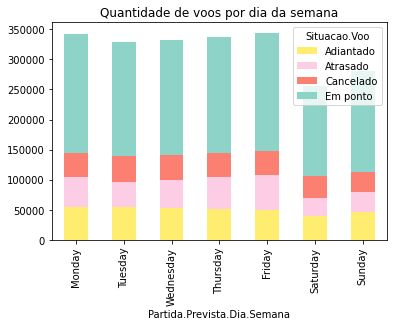

In [18]:
situacao_por_dia_semana.plot(kind='bar', stacked=True, title='Quantidade de voos por dia da semana', colormap='Set3_r')
plt.show()

In [19]:
#Quantidade de voos por companhia dividido por status do voo
situacao_por_companhia = voos_brasil.groupby(['Companhia.Aerea'])['Situacao.Voo'].value_counts().unstack()
situacao_por_companhia = situacao_por_companhia.assign(tmp=situacao_por_companhia.sum(axis=1)).sort_values('tmp', ascending=True).drop('tmp', 1)

In [20]:
situacao_por_companhia

Situacao.Voo,Adiantado,Atrasado,Cancelado,Em ponto
Companhia.Aerea,,,,
TRIP,NaN,NaN,NaN,10.0
TOTAL,599.0,697.0,16.0,3.0
FLYWAYS,30.0,151.0,473.0,1352.0
SETE,224.0,1693.0,511.0,5292.0
MAP LINHAS AEREAS,1940.0,1516.0,666.0,11553.0
PASSAREDO,2845.0,16537.0,12331.0,38723.0
AVIANCA BRASIL,9267.0,31835.0,5995.0,136282.0
TAM,20222.0,68413.0,39589.0,357192.0
GOL,13265.0,86542.0,109850.0,510733.0


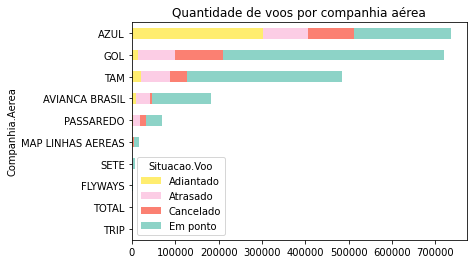

In [21]:
situacao_por_companhia.plot(kind='barh', stacked=True, title='Quantidade de voos por companhia aérea', colormap='Set3_r')
plt.show()

In [22]:
#Usaremos só as 4 maiores companhias nacionais pois as demais não apresentam relevância
voos_brasil = voos_brasil[voos_brasil['Companhia.Aerea'].isin(['AZUL','GOL','TAM','AVIANCA BRASIL'])]

In [23]:
#10 maiores aeroportos por quantidade absoluta de voo
situacao_por_aeroporto_origem = voos_brasil.groupby(['Aeroporto.Origem'])['Situacao.Voo'].value_counts().unstack()
situacao_por_aeroporto_origem = situacao_por_aeroporto_origem.assign(tmp=situacao_por_aeroporto_origem.sum(axis=1)).sort_values('tmp', ascending=True).drop('tmp', 1)

In [24]:
situacao_por_aeroporto_origem = situacao_por_aeroporto_origem[['Atrasado','Adiantado','Cancelado','Em ponto']]

In [25]:
situacao_por_aeroporto_origem.tail(10)

Situacao.Voo,Atrasado,Adiantado,Cancelado,Em ponto
Aeroporto.Origem,,,,
Salgado Filho,8614.0,15617.0,8424.0,47410.0
Afonso Pena,9143.0,16186.0,11929.0,44606.0
Deputado Luis Eduardo Magalhaes,10072.0,8637.0,10730.0,52876.0
Santos Dumont,14221.0,17527.0,11949.0,51733.0
Aeroporto Internacional Do Rio De Janeiro/Galeao,17195.0,6296.0,15097.0,84788.0
Tancredo Neves,19188.0,30600.0,17935.0,67744.0
Viracopos,24897.0,43833.0,23104.0,59147.0
Congonhas,24145.0,9048.0,8847.0,120261.0
Presidente Juscelino Kubitschek,26678.0,11038.0,20673.0,117588.0


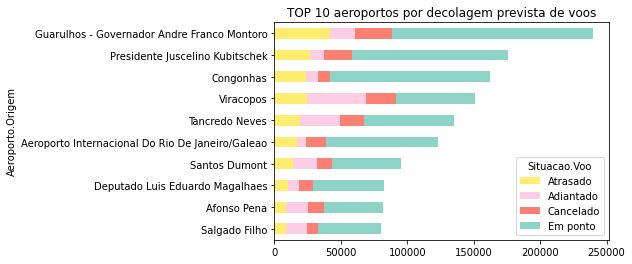

In [26]:
situacao_por_aeroporto_origem.tail(10).plot(kind='barh', stacked=True, title='TOP 10 aeroportos por decolagem prevista de voos', colormap='Set3_r')
plt.show()

In [27]:
#Ordenando os 10 maiores aeroportos por taxa de voos atrasados 
situacao_por_aeroporto_origem_porcentagem = situacao_por_aeroporto_origem.tail(10).stack().groupby(level=0).apply(lambda x: 100*x / x.sum()).unstack()
situacao_por_aeroporto_origem_porcentagem = situacao_por_aeroporto_origem_porcentagem.sort_values(by='Atrasado')

In [28]:
situacao_por_aeroporto_origem_porcentagem = situacao_por_aeroporto_origem_porcentagem[['Atrasado','Adiantado','Cancelado','Em ponto']]

In [29]:
situacao_por_aeroporto_origem_porcentagem

Situacao.Voo,Atrasado,Adiantado,Cancelado,Em ponto
Aeroporto.Origem,,,,
Salgado Filho,10.758759,19.505402,10.521451,59.214388
Afonso Pena,11.168523,19.771817,14.571729,54.487931
Deputado Luis Eduardo Magalhaes,12.235923,10.492620,13.035291,64.236166
Aeroporto Internacional Do Rio De Janeiro/Galeao,13.937070,5.103099,12.236578,68.723252
Tancredo Neves,14.164335,22.588527,13.239387,50.007751
Congonhas,14.876680,5.574827,5.450983,74.097510
Santos Dumont,14.902022,18.366342,12.521220,54.210416
Presidente Juscelino Kubitschek,15.159936,6.272411,11.747558,66.820096
Viracopos,16.490154,29.032130,15.302588,39.175128


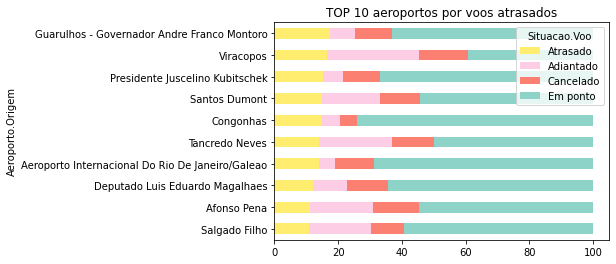

In [30]:
situacao_por_aeroporto_origem_porcentagem.plot(kind='barh', stacked=True, title='TOP 10 aeroportos por voos atrasados', colormap='Set3_r')
plt.show()

In [31]:
#A partir deste resultado serão escolhidos 3 aeroportos com taxas de atraso parecidas para averiguar se os fatores que interferem on atraso são os mesmos
#Aeroportos escolhidos: Juscelino Kubitscheck (BSB, 15.16%), Santos Dumont (SDU, 14.90%) e Congonhas (CGH, 14.88%)

In [32]:
#filtrando apenas os voos com atrasos positivos
voos_brasil_atrasados = voos_brasil[voos_brasil['Situacao.Voo'].isin(['Atrasado'])]

In [33]:
voos_brasil_atrasados['Partida.Atraso'] = voos_brasil_atrasados['Partida.Real'] - voos_brasil_atrasados['Partida.Prevista']
voos_brasil_atrasados['Partida.Atraso'] = voos_brasil_atrasados['Partida.Atraso'].dt.seconds/60
voos_brasil_atrasados = voos_brasil_atrasados[voos_brasil_atrasados['Partida.Atraso'] > 0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
voos_brasil_atrasados.shape

(290516, 26)

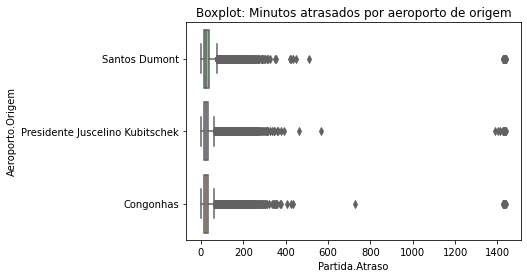

In [35]:
#Detectando outliers atraves de boxplot
aeroportos_interesse = voos_brasil_atrasados[voos_brasil_atrasados['Aeroporto.Origem'].isin(['Presidente Juscelino Kubitschek', 'Santos Dumont', 'Congonhas'])]
sns.boxplot(x='Partida.Atraso', y='Aeroporto.Origem', data=aeroportos_interesse, palette="Accent")
plt.title('Boxplot: Minutos atrasados por aeroporto de origem')
plt.show()

In [36]:
#Separando os 3 aeroportos para obter estatisticas individuais
bsb = voos_brasil_atrasados[voos_brasil_atrasados['Aeroporto.Origem'] == 'Presidente Juscelino Kubitschek']
sdu = voos_brasil_atrasados[voos_brasil_atrasados['Aeroporto.Origem'] == 'Santos Dumont']
cgh = voos_brasil_atrasados[voos_brasil_atrasados['Aeroporto.Origem'] == 'Congonhas']

In [37]:
box_stats_bsb = boxplot_stats(bsb['Partida.Atraso'])
box_stats_sdu = boxplot_stats(sdu['Partida.Atraso'])
box_stats_cgh = boxplot_stats(cgh['Partida.Atraso'])

In [38]:
#Mantendo apenas observações dentro de +- 1.5*IQR (critério de outlier de boxplot)
bsb = bsb[bsb['Partida.Atraso'] < box_stats_bsb[0]['q3']+1.5*box_stats_bsb[0]['iqr']]
sdu = sdu[sdu['Partida.Atraso'] < box_stats_sdu[0]['q3']+1.5*box_stats_sdu[0]['iqr']]
cgh = cgh[cgh['Partida.Atraso'] < box_stats_cgh[0]['q3']+1.5*box_stats_cgh[0]['iqr']]

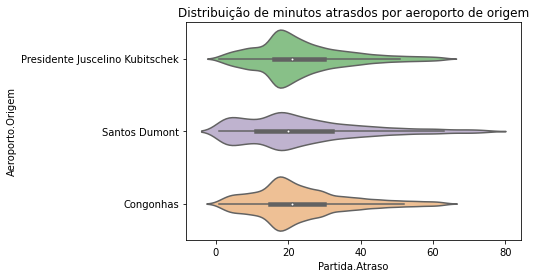

In [39]:
#Distribuição das observações após tratamento para cada aeroporto
aeroportos_interesse = aeroportos_interesse.loc[bsb.index.to_list() + sdu.index.to_list() + cgh.index.to_list()]
sns.violinplot(x='Partida.Atraso', y='Aeroporto.Origem', data=aeroportos_interesse, palette="Accent")
plt.title('Distribuição de minutos atrasdos por aeroporto de origem')
plt.show()